# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Imports

import random
import os

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
    learning_curve
)

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Feature selection
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    VarianceThreshold,
    RFECV,
    SelectFromModel
)
from sklearn.feature_selection import SequentialFeatureSelector

# Dimensionality reduction
from sklearn.decomposition import PCA

# Statistical testing
from scipy.stats import shapiro, randint
import scipy.stats as stats

# Classifiers
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    Lasso,
    LassoCV
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    f1_score
)

# Other utilities
import copy
from sklearn.base import clone
from typing import List, Tuple, Union

# Custom module
from worclipo.load_data import load_data

random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

In [3]:
# Loading data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Split data in features X and labels y
X = data.drop("label",axis=1)
y = data["label"]

# Single train and test split. Is performend with cross-validation at the bottom
#X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.2, random_state=42, stratify=y
#)

The number of samples: 115
The number of columns: 494


Data description

In [4]:
# Basic shape
print(f"Number of samples (rows): {len(data)}")
print(f"Number of features (columns): {len(data.columns)}")

# Data types and non-null info
print("\Dataset info:")
print(data.info())

# Class distribution
print("\n Label distribution (counts):")
print(y.value_counts())


Number of samples (rows): 115
Number of features (columns): 494
\Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, Lipo-001_0 to Lipo-115_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 444.7+ KB
None

 Label distribution (counts):
label
liposarcoma    58
lipoma         57
Name: count, dtype: int64


<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\loisb\AppData\Local\Temp\ipykernel_3432\3539354108.py:6: SyntaxWarning: invalid escape sequence '\D'
  print("\Dataset info:")


Figure data distribution

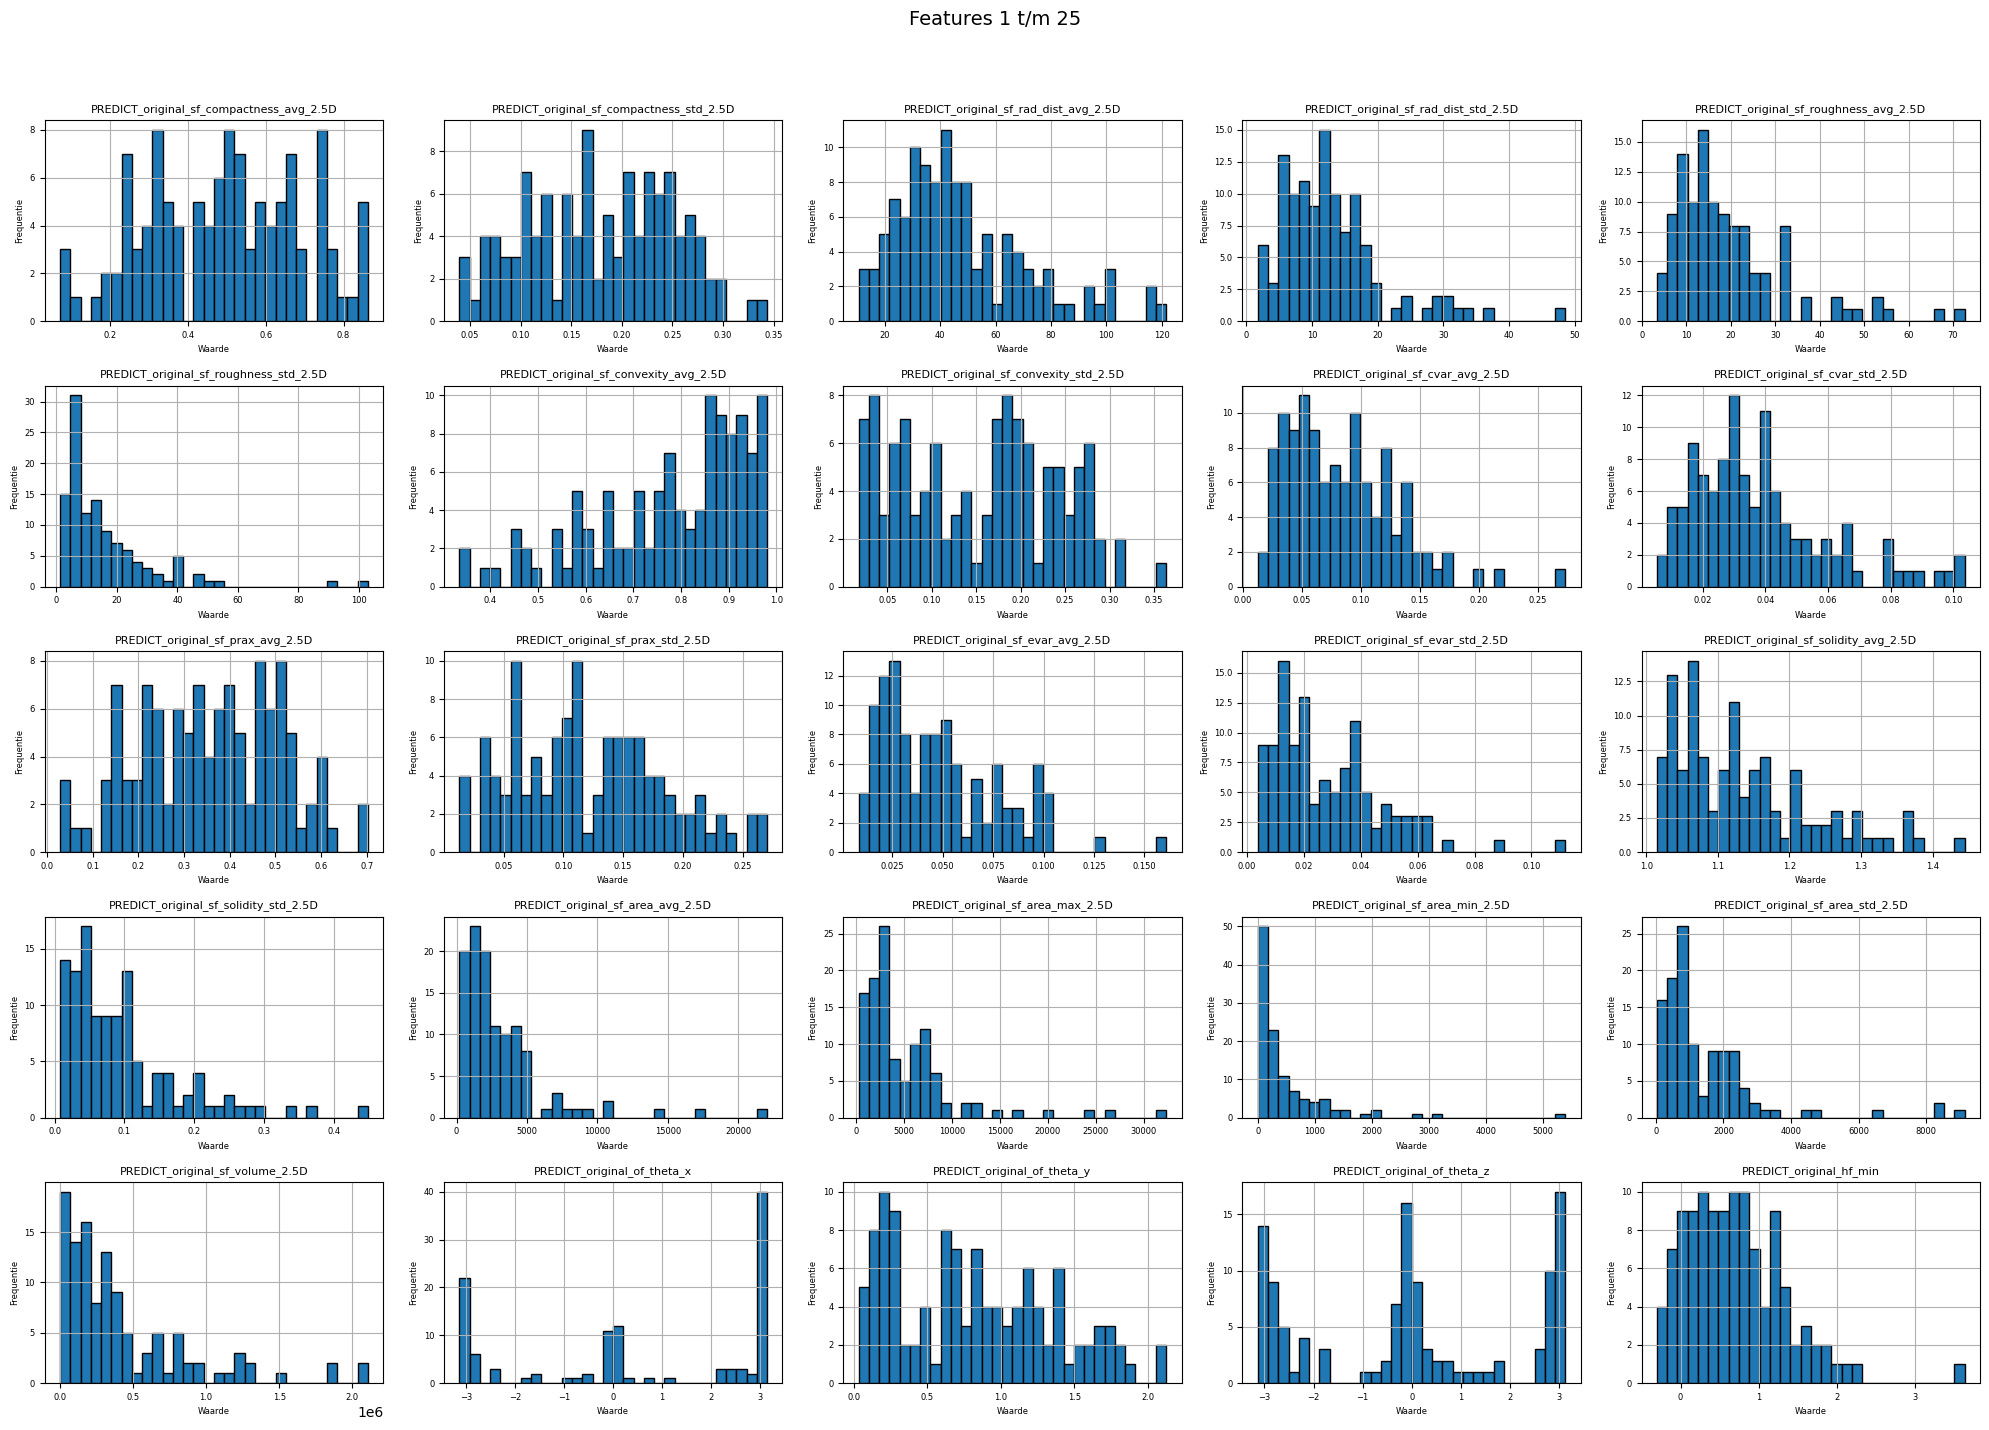

In [5]:
# Selecteer de eerste 25 features
features = X.columns[:25]

'''this code plots the first 25 features of the data set,
it plots the valuses and freqencies of those valuse to show
the data distribution. this is importent for the selection of 
a scaler. the data contains outliers, is not normally distributed 
and had different scales. because of this a robust scaler
is best for thid data.'''

# Plot de histogrammen
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(5, 5, i + 1)
    plt.hist(X[feature].dropna(), bins=30, edgecolor='black')
    plt.title(feature, fontsize=8)
    plt.xlabel("Waarde", fontsize=6)
    plt.ylabel("Frequentie", fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)

plt.suptitle("Features 1 t/m 25", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

General functions to be used

In [6]:
# Some functions we will use

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

### Preprocessing

Missing data
* Part 1: Finding missing data

In [7]:
def find_missing_data(X_train):

    """
    Identifies and counts missing data in a DataFrame using multiple missing value indicators.

    This function scans each column of the input DataFrame for:
    - Standard NaN values
    - Empty strings (i.e., "")
    - Custom missing value indicators (case-insensitive): 'NA', 'N/A', '?', 'None', 'none', '-'

    Parameters:
    -----------
    X_train : pandas.DataFrame
        The input DataFrame to analyze for missing values.

    Returns:
    --------
    pandas.Series
        A Series indexed by column names, containing the total count of missing values per column.
        Only columns with at least one missing value are included in the printed output.
    
    Prints:
    -------
    A Series of columns with non-zero missing value counts and their respective totals.
    """

    # Define missing value indicators
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-']

    # Count NaNs
    nan_counts = X_train.isna().sum()

    # Count empty strings
    empty_string_counts = (X_train == '').sum()

    # Count custom missing indicators (case-insensitive match)
    custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())

    # Compute total missing count per column
    total_missing = nan_counts + empty_string_counts + custom_missing_counts

    # Filter out columns where total missing is zero
    total_missing_selected = total_missing[total_missing != 0]

    # Print total missing counts
    print(total_missing_selected)

    return total_missing

# total_missing = find_missing_data(X_train)

* Part 2: Processing missing data

In [8]:
def process_missing_data(X_train, X_test, total_missing):

    """
    Processes missing data in training and test datasets by handling custom missing indicators,
    removing highly incomplete features, and applying statistical imputation.

    Steps performed:
    1. Replaces custom missing value indicators with `np.nan` in both X_train and X_test.
    2. Drops features with 50% or more missing values in the training set.
    3. Imputes missing numeric values based on statistical tests:
        - Uses Shapiro-Wilk test to check normality.
        - Imputes with mean if normally distributed, otherwise with median.
        - Defaults to median if there are too few data points or no variation.

    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training dataset with potential missing values.

    X_test : pandas.DataFrame
        Test dataset with potential missing values.

    total_missing : pandas.Series
        A Series containing the total missing value counts per column from the training set.

    Returns:
    --------
    tuple of pandas.DataFrame
        A tuple (X_train, X_test) with missing data handled:
        - Features with excessive missing data removed.
        - Remaining missing values imputed appropriately.
    """

    # Replacing missing values with NaN
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-', '']
    X_train.replace(custom_missing, np.nan, inplace=True)
    X_test.replace(custom_missing, np.nan, inplace=True)

    # If 50% or more of the data within one feature is missing the feature is deleted
    limit = len(X_train.index)*50/100
    valid_columns = [col for col, count in total_missing.items() if count < limit]

    # Keep only the valid columns in both X_train and X_test
    X_train = X_train[valid_columns]
    X_test = X_test[valid_columns]

    ## Imputate

    # Check if imputation is needed
    if X_train.isna().sum().sum() == 0:
        pass
    else:
        # Dictionary to store mean/median decision per column
        imputation_strategies = {}

        for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
            col_data = X_train[col].dropna()  # Remove NaN values for testing

            if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
                if col_data.nunique() == 1:  # Check if all values are the same
                    strategy = 'median'  # Default to median if no variability
                else:
                    _, p = shapiro(col_data)
                    strategy = 'mean' if p > 0.05 else 'median'
            else:
                strategy = 'median'  # Default to median if too few values

            imputation_strategies[col] = strategy

        # Create imputers for mean and median
        mean_imputer = SimpleImputer(strategy='mean')
        median_imputer = SimpleImputer(strategy='median')

        # Apply imputers for each feature
        for col, strategy in imputation_strategies.items():
            imputer = mean_imputer if strategy == 'mean' else median_imputer
            X_train[col] = imputer.fit_transform(X_train[[col]])
            X_test[col] = imputer.transform(X_test[[col]])  # Use the same imputer
    
    return X_train, X_test

# X_train, X_test = process_missing_data(X_train, X_test, total_missing)

Scaling data

In [9]:
def scaling(X_train, X_test):
    """
    Scales training and testing feature datasets using RobustScaler.

    This function applies robust scaling to the input training and testing datasets.
    RobustScaler removes the median and scales the data according to the interquartile range (IQR),
    making it more robust to outliers compared to standard scaling techniques.

    Parameters:
    ----------
    X_train : pandas.DataFrame
        The training data to be scaled.
    X_test : pandas.DataFrame
        The testing data to be scaled.

    Returns:
    -------
    X_scaled_robust_train : pandas.DataFrame
        The scaled version of the training dataset.
    X_scaled_robust_test : pandas.DataFrame
        The scaled version of the testing dataset.
    """

    scaler_robust = preprocessing.RobustScaler()

    scaled_robust_array_train = scaler_robust.fit_transform(X_train)
    scaled_robust_array_test = scaler_robust.transform(X_test)

    X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
    X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)

    return X_scaled_robust_train, X_scaled_robust_test

#  X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

### Feature extraction

First step: variance based thresholding

In [10]:
def apply_variance_threshold(X_train, X_test, threshold=0.95):
    """
    Applies variance thresholding to remove low-variance features.

    Args:
        X_train (pd.DataFrame): Scaled training feature set.
        X_test (pd.DataFrame): Scaled test feature set.
        threshold (float): Threshold for variance. Features with variance below this will be removed.

    Returns:
        X_train_filtered (pd.DataFrame): Filtered training set.
        X_test_filtered (pd.DataFrame): Filtered test set.
        selected_features (List[str]): Names of the retained features.
    """
    selector_variance_threshold = VarianceThreshold(threshold=threshold) # Create VarianceThreshold object with given threshold
    X_train_filtered_variance_np = selector_variance_threshold.fit_transform(X_train) # Fit on training set and transform it to remove low-variance features
    selected_features = X_train.columns[selector_variance_threshold.get_support()] # Get names of features that were retained

    X_train_filtered = pd.DataFrame(X_train_filtered_variance_np, columns=selected_features, index=X_train.index) # Rebuild DataFrame for filtered training set
    X_test_filtered = pd.DataFrame(selector_variance_threshold.transform(X_test), columns=selected_features, index=X_test.index) # Apply same transformation to test set

    print(f"[VarianceThreshold] Remaining features: {len(selected_features)}")
    return X_train_filtered, X_test_filtered, selected_features

# X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
# print(X_filtered_train_variance_new.shape)
# print(X_filtered_test_variance_new.shape)

Filtering with ANOVA: linear relations

In [11]:
def select_features_anova(X_train, y_train, X_test, k=75, plot=True):
    """
    Selects the top-k features using ANOVA F-test (for linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features. 
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, visualizes F-statistics and top 2 feature scatter plot.

    Returns:
        X_train_anova (pd.DataFrame): Training set with selected features.
        X_test_anova (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_anova = SelectKBest(f_classif, k=k) # Create a selector using ANOVA F-test to select the top-k features
    X_train_filtered_anova_np = selector_anova.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_anova.get_support()]

    X_train_anova = pd.DataFrame(X_train_filtered_anova_np, columns=selected_features, index=X_train.index)
    X_test_anova = pd.DataFrame(selector_anova.transform(X_test), columns=selected_features, index=X_test.index)

    # print(f"[ANOVA] Selected top-{k} features.")
    return X_train_anova, X_test_anova, selected_features

# Transform labels to numeric values, i.e. 0 or 1
# le = LabelEncoder()
# y_train_numeric = le.fit_transform(y_train)
# legend_labels = le.classes_  # shows mapping from labels to numbers (for plotting/checking)

# X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
# print(anova_selected_features_new)
# print(X_filtered_test_anova_new)

Filtering with mutual information: non-linear relationships

In [12]:
def select_features_mi(X_train, y_train, X_test, k=75, plot=True, random_state=42):
    """
    Selects the top-k features using mutual information (for non-linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, plots MI scores and a 2D scatterplot of top 2 features.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train_mi (pd.DataFrame): Training set with selected features.
        X_test_mi (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_mi = SelectKBest(lambda X, y: mutual_info_classif(X, y, random_state=random_state), k=k) # feature selector using MI as the scoring function
    X_train_filtered_mi_np = selector_mi.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_mi.get_support()]

    X_train_mi = pd.DataFrame(X_train_filtered_mi_np, columns=selected_features, index=X_train.index)
    X_test_mi = pd.DataFrame(selector_mi.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[Mutual Information] Selected top-{k} features.")
    return X_train_mi, X_test_mi, selected_features

# X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)

Take union of ANOVA & MI selected sets: in this way we take linear and non-linear relations in the data

In [13]:
def combine_feature_sets_union(X_full_train, X_full_test, features1, features2):
    """
    Creates a feature subset based on the union of two feature lists.

    Args:
        X_full_train (pd.DataFrame): Original training DataFrame (after variance filtering).
        X_full_test (pd.DataFrame): Original test DataFrame (after variance filtering).
        features1 (List[str]): List of selected features (e.g., from ANOVA).
        features2 (List[str]): List of selected features (e.g., from MI).

    Returns:
        X_union_train (pd.DataFrame): Training set with union of features.
        X_union_test (pd.DataFrame): Test set with union of features.
        union_features (List[str]): Combined list of feature names.
    """
    union_features = list(set(features1).union(set(features2)))
    X_union_train = X_full_train[union_features]
    X_union_test = X_full_test[union_features]

    # print(f"[Feature Union] Combined feature set size: {len(union_features)}")
    return X_union_train, X_union_test, union_features

# X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
# print(len(union_features_new))
# print(union_features_new)

In [14]:
# Bijvoorbeeld op een paar features uit union:
#for feature in union_features_new[:70]:  # check bijv. eerste 5 features
    # sns.histplot(X_filtered_train_union_new[feature], kde=True)
    # plt.title(f'Distribution of {feature}')
    # plt.show()

    #stat, p = stats.shapiro(X_filtered_train_union_new[feature])
    #print(f"{feature}: p={p} (Shapiro-Wilk Test)")
    #if p > 0.05:
        #print(f"Feature {feature} follows a normal distribution")


In [15]:
from sklearn.model_selection import cross_val_score

def greedy_forward_selection(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, list, np.ndarray],
    X_test: pd.DataFrame,
    model=None,
    feature_range: List[int] = None,
    scoring: str = 'accuracy',
    cv_splits: int = 5,
    plot: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], int, float]:
    """
    Applies greedy forward feature selection with a given model.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (array-like): Training labels.
        X_test (pd.DataFrame): Test features.
        model: Scikit-learn classifier (default: LogisticRegression).
        feature_range (list): List of n_features_to_select to evaluate.
        scoring (str): Scoring metric (e.g. 'accuracy', 'roc_auc').
        cv_splits (int): Number of folds for cross-validation.
        plot (bool): Whether to plot accuracy vs. feature count.

    Returns:
        X_train_selected (pd.DataFrame): Selected training features.
        X_test_selected (pd.DataFrame): Selected test features.
        best_features (List[str]): Names of selected features.
        best_n_features (int): Number of selected features.
        best_accuracy (float): Training accuracy using selected features.
    """
    if model is None:
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000, random_state=42) # Use default Logistic Regression if no model is passed

    if feature_range is None:
        total_features = X_train.shape[1] # Get number of features
        minimum_number_to_select = 1
        maximum_number_to_select = total_features
        stepsize = 1
        feature_range = list(range(minimum_number_to_select, maximum_number_to_select+1, stepsize)) # Default: test all possible feature counts

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42) # Define cross-validation strategy

    best_accuracy = 0
    best_n_features = None
    best_features = []
    accuracy_list = []

    for n_features in feature_range:
        print(f"Testing n_features_to_select = {n_features}")

        sfs = SequentialFeatureSelector(
            model,
            n_features_to_select=n_features, # Number of features to select in this round
            direction='forward', # Add features one at a time
            scoring=scoring, # Use specified scoring metric
            cv=cv,
            n_jobs=-1 # Use all CPU cores
        )
        sfs.fit(X_train, y_train) # Perform feature selection
        selected = list(X_train.columns[sfs.get_support()]) # Get names of selected features

        X_train_sel = X_train[selected]
        X_test_sel = X_test[selected]

        # new model per run
        current_model = clone(model) # Clone model to ensure fresh state
        current_model.fit(X_train_sel, y_train) # Train the model on selected features
        acc = cross_val_score(current_model, X_train_sel, y_train, cv=cv, scoring=scoring).mean()
        # acc = current_model.score(X_train_sel, y_train)
        accuracy_list.append(acc)

        print(f"Accuracy for {n_features} features: {acc:.4f}")

        if acc > best_accuracy: # Check if this is the best so far
            best_accuracy = acc
            best_n_features = n_features
            best_features = selected

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(feature_range, accuracy_list, marker='o') # Plot accuracy per feature count
        plt.xlabel("Number of Features")
        plt.ylabel(f"Training {scoring.capitalize()}")
        plt.title("Greedy Forward Selection Performance")
        plt.grid(True)
        plt.show()

    print("\n Greedy Forward Selection complete.")
    print(f"Optimal number of features: {best_n_features}")
    print(f"Best training {scoring}: {best_accuracy:.4f}")

    X_train_best = X_train[best_features] # Final training set with selected features
    X_test_best = X_test[best_features] # Final test set with selected features

    return X_train_best, X_test_best, best_features, best_n_features, best_accuracy

# Feature selection for the Logistic Regression Classifier
# Base estimator = Linear Regression
# Optimize number of features between 10 and the number of features in the union
# X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, sfs_selected_features_logistic, number_of_sfs_selected_features_logistic, train_acc_logistic = greedy_forward_selection(
#     X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
#     model=LogisticRegression(max_iter=1000, random_state=42),
#     feature_range=list(range(11, 22, 1)),
#     scoring='accuracy'
# )

In [16]:
# Feature selection for the SVM classifier
# Base estimator = Linear Regression
# Optimize number of features with a max of 10
# X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, sfs_selected_features_logistic_max10, number_of_sfs_selected_features_logistic_max10, train_acc_logistic_max10 = greedy_forward_selection(
#     X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
#     model=LogisticRegression(max_iter=1000, random_state=42),
#     feature_range=list(range(1, 21, 1)),
#     scoring='accuracy'
# )

In [ ]:
# First optimize k with grid search before using kNN as base esimator in the greedy forward

def optimal_k(X_filtered_train_union_new, y_train_numeric):
    """
    Performs grid search to find the optimal number of neighbors (k) for a K-Nearest Neighbors (KNN) classifier
    using cross-validation, and returns a KNN model initialized with the best k.

    Args:
        X_filtered_train_union_new (pd.DataFrame): Preprocessed training features.
        y_train_numeric (array-like): Numeric-encoded training labels.

    Returns:
        knn_best (KNeighborsClassifier): A KNN classifier with the best number of neighbors found via cross-validation.
    """

    # Temporarily train on all union features
    X_temp = X_filtered_train_union_new

    # Define parameter grid: test k values from 1 to 20
    param_grid = {'n_neighbors': list(range(1, 21))}

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        KNeighborsClassifier(), # Base model: k-Nearest Neighbors
        param_grid,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
    )

    # Run the grid search on the training data
    grid_search.fit(X_temp, y_train_numeric)

    # Get best k
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Cross-validated accuracy: {grid_search.best_score_:.4f}")

    # Create a new KNN model using the best k
    knn_best = KNeighborsClassifier(n_neighbors=best_k)

    return knn_best, best_k

# knn_best = optimal_k(X_filtered_train_union_new, y_train_numeric)

In [18]:
# Feature selection for the kNN classifier
# Base estimator = kNN classifier
# Optimize number of features between 1 and the number of features in the union
# X_train_selected_sfs_knn, X_test_selected_sfs_knn, sfs_selected_features_knn, number_of_sfs_selected_features_knn, train_acc_knn = greedy_forward_selection(
#     X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
#     model=knn_best,
#     feature_range=list(range(22, 33, 1)),
#     scoring='accuracy'
# )

In [19]:
#print(sfs_selected_features_knn)

Datasets after feature extraction

In [20]:
#X_train_selected_final = X_train_selected_sfs
#print(X_train_selected_final.shape)
#X_test_selected_final = X_test_selected_sfs
#print(X_test_selected_final.shape)
#selected_features_final = sfs_selected_features
#print(len(selected_features_final))

Encode the categorical y-labels to numerical values

In [21]:
def y_numeric(y_train, y_test):
    """
    Encodes categorical labels from `y_train` and `y_test` into numeric values using `LabelEncoder`.

    This function applies `LabelEncoder` from `sklearn.preprocessing` to transform categorical target 
    labels into numerical format, which is essential for machine learning models that require numeric inputs.

    Args:
        y_train (pd.Series): The training labels.
        y_test (pd.Series): The test labels.

    Returns:
        tuple: A tuple containing:
            - `y_train_numeric` (numpy.ndarray): The transformed numeric labels for the training set.
            - `y_test_numeric` (numpy.ndarray): The transformed numeric labels for the test set.

    Prints:
        - A dictionary mapping numeric labels to their corresponding original class names.

    Note:
        The function assumes `y_train` and `y_test` contain categorical labels.
    """
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train)
    y_test_numeric = le.transform(y_test)

    # Store the mapping of labels
    legend_labels = le.classes_  # This saves the original class names
    print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})

    return y_train_numeric, y_test_numeric


Optimization based feature selection: LASSO

In [ ]:
def lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric):
    """
    Performs optimization based feature selection using Lasso regression.

    This function applies Lasso regression with automatic hyperparameter tuning 
    (via `LassoCV`) to identify the most important features from the robust training data.
    It selects features by penalizing less important coefficients, setting some to zero.
    
    Args:
        X_scaled_robust_train (pd.DataFrame): 
            The robust training dataset with numerical features.

    Returns:
        tuple: A tuple containing:
            - `X_train_selected` (np.ndarray): The reduced training dataset containing only selected features.
            - `X_test_selected` (np.ndarray): The reduced test dataset containing only selected features.
    
    Prints:
        - The best `alpha` value found through cross-validation.
        - The names of the selected features.

    Note:
        - This function assumes `y_train_numeric` is globally defined.
        - `SelectFromModel` is used to remove unimportant features based on the Lasso model.
    """

    # Ensure we're working with NumPy arrays for dot product
    X_np = X_scaled_robust_train.values if hasattr(X_scaled_robust_train, "values") else X_scaled_robust_train
    y_np = y_train_numeric.values if hasattr(y_train_numeric, "values") else y_train_numeric
    
    # Calculate the maximum useful alpha
    alpha_max = np.max(np.abs(X_np.T @ y_np)) / len(y_np)

    # Define LassoCV with cross-validation
    n_alphas = 200
    alphas = np.logspace(np.log10(alpha_max) - 4, np.log10(alpha_max), n_alphas)
    
    # Cross-validated Lasso
    random_state = 42 #  Using this will produce the same results everytime, 42 is along 0 the most popular choice
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(cv=cv_strategy, alphas=alphas, random_state=random_state, max_iter=10000) 
    lasso_cv.fit(X_scaled_robust_train, y_train_numeric)

    # Get the best alpha value
    best_alpha = lasso_cv.alpha_
    alpha_info = [best_alpha, alpha_max]

    # Train final Lasso model with optimal alpha
    lasso = Lasso(alpha=best_alpha, fit_intercept=True) #Exclude the intercept term since the data is already centered
    lasso.fit(X_scaled_robust_train, y_train_numeric)

    # Select features
    selector = SelectFromModel(lasso, prefit=True) #Use prefit=True since the model has already been trained and fitted earlier
    X_train_selected = selector.transform(X_scaled_robust_train)
    X_test_selected = selector.transform(X_scaled_robust_test)

    # Get selected feature indices and names
    selected_features = np.where(selector.get_support())[0]
    selected_feature_names = X_scaled_robust_train.columns[selected_features]
    n_features = len(selected_features)
    
    return alpha_info, X_train_selected, X_test_selected, selected_feature_names, n_features

# Capture the return values when calling the function
#alpha_info, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)
#y_train_numeric, y_test_numeric = y_numeric(y_train, y_test)
# Print the captured values in the global scope
#print(f"Best alpha found: {best_alpha}")
#print("Selected Features:", selected_feature_names)
#print(f"N features found: {n_features}")



PCA feature extraction

In [23]:
#alpha_info, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)

def PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95):
    """
    Performs Principal Component Analysis (PCA) for feature reduction.

    This function applies PCA to reduce the dimensionality of the input data, 
    transforming the training and test datasets to a lower number of features 
    (specified by `n_features`), while retaining as much variance as possible.

    Args:
        n_features (int): 
            The number of principal components to retain after performing PCA.
            Based on the number of features of Lasso.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_robust_train_PCA` (np.ndarray): The transformed training dataset with reduced features.
            - `X_scaled_robust_test_PCA` (np.ndarray): The transformed test dataset with reduced features.

    Notes:
        - The function assumes `X_scaled_robust_train` and `X_scaled_robust_test` are predefined globally.
        - The function applies the same transformation to both the training and test datasets, 
          ensuring that the test set is projected into the same lower-dimensional space as the training set.
    """
    pca = PCA(n_components=target_variance)
    X_train_PCA = pca.fit_transform(X_scaled_robust_train)
    X_test_PCA = pca.transform(X_scaled_robust_test)  # Use the same transformation

    # Determine how many components were selected
    n_components_selected = pca.n_components_

    print(f"Selected {n_components_selected} components to retain {target_variance*100}% variance.")

    return pca, X_train_PCA, X_test_PCA, n_components_selected

# Assuming you already have the transformed PCA data
#pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95)
#alpha_info, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)

# Plot the cumulative variance versus the number of components
#plt.figure(figsize=(8,5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
#plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
#plt.axvline(x=n_components_selected, color='g', linestyle='--', label=f"{n_components_selected} Components")
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components')
#plt.legend()
#plt.grid()
#plt.show()

Testing feature selections 

In [24]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_lasso(X_train_sel_lasso, y_train_numeric, knn_best):
    """
    Tests multiple classifiers on Lasso-selected features using cross-validation.

    This function trains and evaluates a set of classifiers (Logistic Regression and k-NN)
    using features selected through Lasso regression. It performs stratified 5-fold 
    cross-validation and prints accuracy scores for each model.

    Args:
        X_train_sel_lasso (np.ndarray or pd.DataFrame): 
            The training dataset after Lasso-based feature selection.
        y_train_numeric (np.ndarray or pd.Series): 
            The numeric labels for the training data.

    Returns:
        None. 
        The function prints out accuracy scores for each classifier.
    """
    # Define the classifiers
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=knn_best)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected = X_train_sel_lasso

    # Iterate through each classifier for training and evaluation
    for clf_name, clf in classifiers.items():
        # Perform cross-validated predictions (simulates test set predictions within training folds)
        Y_pred = cross_val_predict(clf, X_train_selected, y_train_numeric, cv=cv)

        # Store a copy of the fitted classifier (useful if you want to reuse or analyze later)
        clfs_fit.append(copy.deepcopy(clf))

        # Calculate accuracy score between actual and predicted labels
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Display results for the current classifier
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print("-" * 50)

#test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_train_numeric)

In [25]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_pca(X_train_pca, y_train_numeric, knn_best):
    """
    Tests multiple classifiers on PCA-reduced features using cross-validation.

    This function trains and evaluates a set of classifiers (Logistic Regression and k-NN)
    using PCA-transformed training data. It performs stratified 5-fold cross-validation 
    and prints the accuracy score for each classifier.

    Args:
        X_train_pca (np.ndarray): 
            The training dataset transformed using PCA.
        y_train_numeric (np.ndarray or pd.Series): 
            The numeric target labels for the training data.

    Returns:
        None.
        Prints classification accuracy for each model.
    """
    # Define the classifiers to evaluate
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=knn_best)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected_pca = X_train_pca

    # Iterate through each classifier for training and evaluation
    for clf_name, clf in classifiers.items():
        # Perform cross-validated predictions (simulates test set predictions within training folds)
        Y_pred = cross_val_predict(clf, X_train_selected_pca, y_train_numeric, cv=cv)

        # Save a copy of the classifier object
        clfs_fit.append(copy.deepcopy(clf))

        # Compute accuracy between predicted and actual labels
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Display results for the current classifier
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print("-" * 50)

#test_pca(X_train_pca, X_test_pca, y_train_numeric)

## Model selection
Random forest, decision tree and bagging

In [ ]:
def forest_tree_classifiers(y_train, X_train):

    """
    Trains and tunes multiple tree-based classifiers using randomized hyperparameter search.

    This function performs the following steps:
    1. Encodes categorical target labels using `LabelEncoder`.
    2. Defines and tunes three classifiers:
       - Random Forest
       - Bagging with Decision Trees
       - Standalone Decision Tree
    3. Uses `RandomizedSearchCV` for hyperparameter optimization with 10-fold cross-validation.
    4. Prints the best parameters and accuracy score for each model.

    Parameters:
    -----------
    y_train : array-like or pandas.Series
        The target values (class labels) for training.

    X_train : pandas.DataFrame
        The training features.

    Returns:
    --------
    tuple:
        - best_estimators : dict
            A dictionary with model names as keys and their best-fitted estimators as values.

        - y_train_encoded : numpy.ndarray
            The label-encoded version of `y_train`.

        - best_scores : dict
            A dictionary with model names as keys and their best cross-validated accuracy scores as values.

    Prints:
    -------
    Best estimator, hyperparameters, and cross-validation accuracy for each model.
    """

    # Encode categorical labels in numerical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Define models and parameter distributions
    models = {
        "Random Forest": (RandomForestClassifier(random_state=42), { #Hyperparameters for random forest
            'n_estimators': randint(5, 200), # Number of trees
            'max_depth': randint(3, 20),
            'min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Bagging": (BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), { #Hyperparameters for bagging of a decision tree
            'n_estimators': randint(5, 200), # Number of trees
            'estimator__max_depth': randint(3, 5),
            'estimator__min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Decision Tree": (DecisionTreeClassifier(random_state=42), { #Hyperparameters for decision tree
            'max_depth': randint(3, 5),
            'min_samples_split': randint(5, 20)
        })
    }

    # Perform Randomized Search and store results
    best_estimators = {}
    best_params = {}
    best_scores = {}

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Randomized Search
    for name, (model, param_dist) in models.items(): # Perform for the three different classifiers 
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=30, # Number of points in grid search
            scoring='accuracy',
            cv=cv_strategy, # 10-fold cross-validation
            n_jobs=-1, # To improve computation time
            random_state=42
        )
        search.fit(X_train, y_train_encoded) # Fitted on data without scaling and feature selection

        # Find parameters for the three models with the highest mean accuracy
        best_estimators[name] = search.best_estimator_ 
        best_params[name] = search.best_params_
        best_scores[name] = search.best_score_

    # Print results
    print("\n=== Model Comparison ===")
    for model_name in models.keys():
        print(f"\nBest {model_name}: {best_estimators[model_name]}")
        print(f"Best {model_name} Parameters: {best_params[model_name]}")
        print(f"Best {model_name} Accuracy: {best_scores[model_name]:.4f}")

    # Return best hyperparameters for the three models including accuracies (best_scores)
    return best_estimators, y_train_encoded, best_scores

#best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)

SVM

In [ ]:
def svm_classifier(X_train_selected_final, y_train_encoded):

    """
    Trains and tunes a Support Vector Machine (SVM) classifier using randomized hyperparameter search.

    This function:
    1. Defines a base SVM model with probability estimates enabled.
    2. Performs hyperparameter tuning using `RandomizedSearchCV` with 10-fold cross-validation.
       - Searches over different values of regularization (C), kernel types, and kernel coefficients (gamma).
    3. Fits the model to the provided training data (which should be preprocessed and feature-selected).
    4. Prints and returns the best model along with its accuracy score.

    Parameters:
    -----------
    X_train_selected_final : pandas.DataFrame or numpy.ndarray
        The final preprocessed and feature-selected training features.

    y_train_encoded : numpy.ndarray
        Label-encoded target values for training.

    Returns:
    --------
    tuple:
        - best_svm : sklearn.svm.SVC
            The best-performing SVM model after hyperparameter tuning.

        - best_score_svm : float
            The best cross-validation accuracy score achieved by the tuned SVM model.

    Prints:
    -------
    Best SVM model, its optimal hyperparameters, and corresponding cross-validation accuracy.
    """

    # Define base SVM model
    svm_model = SVC(probability=True, random_state=42) # probability=True so predict_proba can be used later to calculate ROC and AUC

    # Define parameter distribution for RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter --> how many slack is allowed
        'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
        'kernel': ['linear', 'rbf'],  # Different kernel types
    }

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Randomized Search with cv=10
    random_search = RandomizedSearchCV(
        estimator=svm_model,
        param_distributions=param_dist,
        n_iter=30, # Number of points in grid search
        scoring='accuracy',
        cv=cv_strategy,  # 10-fold cross-validation
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )

    # Fit on robustly scaled training data after feature selection
    random_search.fit(X_train_selected_final, y_train_encoded)

    # Get the best model and parameters
    best_svm = random_search.best_estimator_
    best_params_svm = random_search.best_params_
    best_score_svm = random_search.best_score_

    # Print results
    print("\n=== Best SVM Model After Randomized Search ===")
    print(f"Best SVM: {best_svm}")
    print(f"Best SVM Parameters: {best_params_svm}")
    print(f"Best SVM Accuracy: {best_score_svm:.4f}")

    # Return model with best hyperparameters (best_svm) and accuracy score (best_score_svm)
    return best_svm, best_score_svm

#best_svm, best_score_svm = svm_classifier(X_train_selected_sfs_logistic_max10, y_train_encoded)

kNN

In [28]:
def knn_classifier(X_train_selected_final, y_train_encoded):

    """
    This function performs a k-Nearest Neighbors (kNN) classification using RandomizedSearchCV for hyperparameter optimization.

    It initializes a kNN classifier, sets up a parameter distribution for RandomizedSearchCV, and applies StratifiedKFold 
    cross-validation with 10 splits. The search for the best hyperparameters is performed over a number of iterations 
    to maximize classification accuracy.

    Parameters:
    X_train_selected_final (array-like or pandas DataFrame): The feature matrix of the training data.
    y_train_encoded (array-like): The target labels for the training data, encoded for classification.

    Returns:
    tuple: A tuple containing the best kNN classifier model and its corresponding accuracy score.
        - best_knn (KNeighborsClassifier): The kNN model with the best hyperparameters found by RandomizedSearchCV.
        - best_score_knn (float): The best accuracy score achieved during the search.

    The function also prints out the best kNN model, its parameters, and the achieved accuracy.
    """

    # Define base kNN model
    knn_model = KNeighborsClassifier()

    # Define parameter distribution for RandomizedSearchCV
    param_dist_knn = {
        'n_neighbors': randint(3, 50),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    }

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    random_search_knn = RandomizedSearchCV(
        estimator=knn_model,
        param_distributions=param_dist_knn,
        n_iter=30,
        scoring='accuracy',
        cv=cv_strategy,  
        n_jobs=-1,
        random_state=42
    )

    # Fit op geschaalde data
    random_search_knn.fit(X_train_selected_final, y_train_encoded)

    # Beste model, parameters, en score ophalen
    best_knn = random_search_knn.best_estimator_
    best_params_knn = random_search_knn.best_params_
    best_score_knn = random_search_knn.best_score_

    # Resultaten afdrukken
    print("\n=== Best kNN Model After Randomized Search ===")
    print(f"Best kNN: {best_knn}")
    print(f"Best kNN Parameters: {best_params_knn}")
    print(f"Best kNN Accuracy: {best_score_knn:.4f}")

    return best_knn, best_score_knn

#best_knn, best_score_knn = knn_classifier(X_train_selected_sfs_knn, y_train_encoded)

Logistic regression

In [ ]:
def lr_classifier(X_train_selected_final, y_train_encoded):

    """
    Trains and evaluates a Logistic Regression classifier using cross-validation.

    This function:
    1. Defines a Logistic Regression model with an increased maximum number of iterations.
    2. Evaluates the model using 10-fold cross-validation.
    3. Computes and prints the mean cross-validated accuracy score.

    Parameters:
    -----------
    X_train_selected_final : pandas.DataFrame or numpy.ndarray
        The final feature-selected and preprocessed training feature set.

    y_train_encoded : numpy.ndarray
        Label-encoded target values for training.

    Returns:
    --------
    tuple:
        - log_reg_score : float
            The mean cross-validation accuracy score.

        - log_reg_model : sklearn.linear_model.LogisticRegression
            The initialized Logistic Regression model (not yet fitted to the entire dataset).

    Prints:
    -------
    Cross-validated accuracy score for the Logistic Regression model.
    """

    # Function to perform cross-validation and get accuracy
    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    def perform_cross_val(model, X, y, cv=cv_strategy):
        return np.mean(cross_val_score(model, X, y, cv=cv, scoring='accuracy')) # Returns mean accuracy after 10-fold cross-validation

    # Perform cross-validation for Logistic Regression with default parameters
    log_reg_model = LogisticRegression(max_iter=5000) # max_iter is set higher to prevent warnings that max was reached
    log_reg_score = perform_cross_val(log_reg_model, X_train_selected_final, y_train_encoded) # Performed on scaled data after feature selection
    print(f"\nAccuracy for Logistic Regression: {log_reg_score:.4f}")

    # Return model with best hyperparameters (log_reg_model) with accuracy (log_reg_score)
    return log_reg_score, log_reg_model

#log_reg_score, log_reg_model = lr_classifier(X_train_selected_sfs_logistic, y_train_encoded)

## Learning curves

In [ ]:
def learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model, best_svm):

    """
    Plots learning curves for multiple classifiers to visualize model performance as a function of training set size.

    This function:
    1. Uses pre-trained or best-estimated models
    2. Calls a helper function `plot_learning_curve` (assumed to be defined elsewhere) for each model.
    3. Uses 10-fold cross-validation for consistent performance estimates.
    4. Displays learning curves in a 3x2 subplot layout.

    Parameters:
    -----------
    best_estimators : dict
        Dictionary of best-fitted tree-based models from `forest_tree_classifiers`, keyed by model name.

    best_knn : sklearn.neighbors.KNeighborsClassifier
        Best-performing kNN model.

    X_train_selected_sfs_logistic : array-like
        Feature subset used for Logistic Regression.

    X_train_selected_sfs_logistic_max10 : array-like
        Logistic Regression feature subset (up to 10 features) used for SVM.

    X_train_selected_sfs_knn : array-like
        Feature subset selected for the kNN model.

    log_reg_model : sklearn.linear_model.LogisticRegression
        Logistic Regression model (not necessarily trained).

    best_svm : sklearn.svm.SVC
        Best-performing SVM model after hyperparameter tuning.

    Displays:
    ---------
    A 3x2 grid of learning curves for visual comparison of model generalization performance.
    """

    # Create subplots (3 rows, 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Plot learning curves for each best model
    # plot_learning_curve uses learning_curve function 
    # For each classifier the features are used that are used for training the classifier
    plot_learning_curve(best_svm, "SVM Learning Curve", X_train_selected_sfs_logistic_max10, y_train_encoded, axes[0, 0], cv=cv_strategy)
    plot_learning_curve(best_estimators["Random Forest"], "Random Forest Learning Curve", X_train, y_train_encoded, axes[0, 1], cv=cv_strategy)
    plot_learning_curve(best_estimators["Bagging"], "Bagging Classifier Learning Curve", X_train, y_train_encoded, axes[1, 0], cv=cv_strategy)
    plot_learning_curve(best_estimators["Decision Tree"], "Decision Tree Learning Curve", X_train, y_train_encoded, axes[1, 1], cv=cv_strategy)
    plot_learning_curve(best_knn, "kNN Learning Curve", X_train_selected_sfs_knn, y_train_encoded, axes[2, 0], cv=cv_strategy)
    plot_learning_curve(log_reg_model, "Linear Regression Learning Curve", X_train_selected_sfs_logistic, y_train_encoded, axes[2, 1], cv=cv_strategy)


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

#learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model, best_svm)


## Evaluation

In [31]:
def evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators, best_svm, best_score_svm):

    """
    Evaluates the best-performing classifier on the test dataset and generates performance metrics.

    This function:
    1. Compares model performance across all trained classifiers based on cross-validation scores.
    2. Identifies the best-performing model (highest validation accuracy).
    3. Fits the best model on the appropriate training set and evaluates it on the corresponding test set.
    4. Calculates and prints classification performance metrics: accuracy and F1 score.
    5. Generates the ROC curve and computes AUC score.

    Parameters:
    -----------
    best_scores : dict
        Cross-validated accuracy scores for Random Forest, Bagging, and Decision Tree models.

    best_score_knn : float
        Best cross-validated accuracy score for the kNN model.

    X_scaled_robust_train : array-like
        Robustly scaled training set used for tree-based classifiers.

    X_scaled_robust_test : array-like
        Robustly scaled test set corresponding to `X_scaled_robust_train`.

    best_knn : sklearn classifier
        Trained k-Nearest Neighbors classifier.

    X_train_selected_sfs_logistic : array-like
        Training set with selected features for Logistic Regression.

    X_test_selected_sfs_logistic : array-like
        Corresponding test set for Logistic Regression.

    X_train_selected_sfs_logistic_max10 : array-like
        Feature-selected training set (up to 10 features) for SVM.

    X_test_selected_sfs_logistic_max10 : array-like
        Corresponding test set for SVM.

    X_train_selected_sfs_knn : array-like
        Feature-selected training set for kNN.

    X_test_selected_sfs_knn : array-like
        Corresponding test set for kNN.

    log_reg_score : float
        Cross-validated accuracy score for Logistic Regression.

    best_estimators : dict
        Dictionary of trained tree-based classifiers.

    best_svm : sklearn.svm.SVC
        Trained SVM model with tuned hyperparameters.

    best_score_svm : float
        Cross-validated accuracy score for the SVM model.

    Returns:
    --------
    tuple:
        - fpr : array
            False Positive Rate values for ROC curve.
        - tpr : array
            True Positive Rate values for ROC curve.
        - auc_value : float
            Area Under the Curve (AUC) score for the selected model.

    Prints:
    -------
    - Best model based on accuracy.
    - Final accuracy and F1 score on the test set.
    - ROC curve is displayed.
    """

    # Store model names and best accuracy scores
    model_scores = {
        "Random Forest": best_scores["Random Forest"],
        "Bagging": best_scores["Bagging"],
        "Decision Tree": best_scores["Decision Tree"],
        "SVM": best_score_svm,
        "kNN": best_score_knn,
        "Logistic Regression": log_reg_score
    }

    # Identify the best model, so the model with the highest accuracy
    best_model_name = max(model_scores, key=model_scores.get)
    print(f"\nBest Overall Model: {best_model_name}")

    # Determine the correct dataset and fit the best model
    if best_model_name in best_estimators:  # Models trained on X_scaled_robust_train
        best_model = best_estimators[best_model_name]
        best_model.fit(X_scaled_robust_train, y_train_encoded)
        y_score = best_model.predict_proba(X_scaled_robust_test) # Used for AUC and ROC
        y_pred = best_model.predict(X_scaled_robust_test) # Used for accuracy and f1-score
        
    elif best_model_name == "SVM":
        best_model = best_svm
        best_model.fit(X_train_selected_sfs_logistic_max10, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_logistic_max10)
        y_pred = best_model.predict(X_test_selected_sfs_logistic_max10)

    elif best_model_name == "kNN":
        best_model = best_knn
        best_model.fit(X_train_selected_sfs_knn, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_knn)
        y_pred = best_model.predict(X_test_selected_sfs_knn)

    elif best_model_name == "Logistic Regression":
        best_model = LogisticRegression(max_iter=5000)
        best_model.fit(X_train_selected_sfs_logistic, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_logistic)
        y_pred = best_model.predict(X_test_selected_sfs_logistic)

    # Print results
    print(f"\nFinal Model: {best_model_name}")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)

    # Print the accuracy and F1 score
    print(f"Accuracy on the Test Set: {accuracy:.4f}")
    print(f"F1 Score on the Test Set: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, auc_value = plot_roc_curve(y_score, y_test_encoded)

    # Return values for ROC curve and AUC
    return fpr, tpr, auc_value

#fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistics_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators, best_svm, best_score_svm)


## Performance estimate

==============================START ONE FOLD==============================
Series([], dtype: int64)
------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 181


C:\Users\loisb\AppData\Local\Temp\ipykernel_3432\1609714090.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_3432\1609714090.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


[Mutual Information] Selected top-75 features.
Testing n_features_to_select = 10
Accuracy for 10 features: 0.8380
Testing n_features_to_select = 11
Accuracy for 11 features: 0.8380
Testing n_features_to_select = 12
Accuracy for 12 features: 0.8386
Testing n_features_to_select = 13
Accuracy for 13 features: 0.8386
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8386
Testing n_features_to_select = 15
Accuracy for 15 features: 0.8386
Testing n_features_to_select = 16
Accuracy for 16 features: 0.8386
Testing n_features_to_select = 17
Accuracy for 17 features: 0.8386
Testing n_features_to_select = 18
Accuracy for 18 features: 0.8386
Testing n_features_to_select = 19
Accuracy for 19 features: 0.8386
Testing n_features_to_select = 20
Accuracy for 20 features: 0.8386


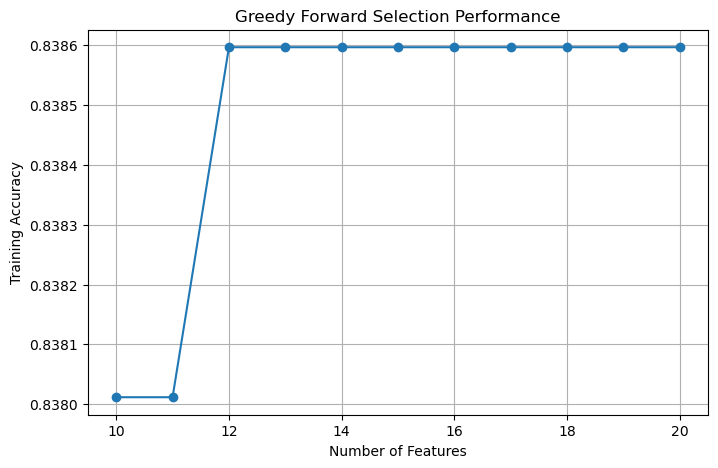


 Greedy Forward Selection complete.
Optimal number of features: 12
Best training accuracy: 0.8386
Testing n_features_to_select = 10
Accuracy for 10 features: 0.8380
Testing n_features_to_select = 11
Accuracy for 11 features: 0.8380
Testing n_features_to_select = 12
Accuracy for 12 features: 0.8386
Testing n_features_to_select = 13
Accuracy for 13 features: 0.8386
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8386
Testing n_features_to_select = 15
Accuracy for 15 features: 0.8386
Testing n_features_to_select = 16
Accuracy for 16 features: 0.8386
Testing n_features_to_select = 17
Accuracy for 17 features: 0.8386
Testing n_features_to_select = 18
Accuracy for 18 features: 0.8386
Testing n_features_to_select = 19
Accuracy for 19 features: 0.8386
Testing n_features_to_select = 20
Accuracy for 20 features: 0.8386


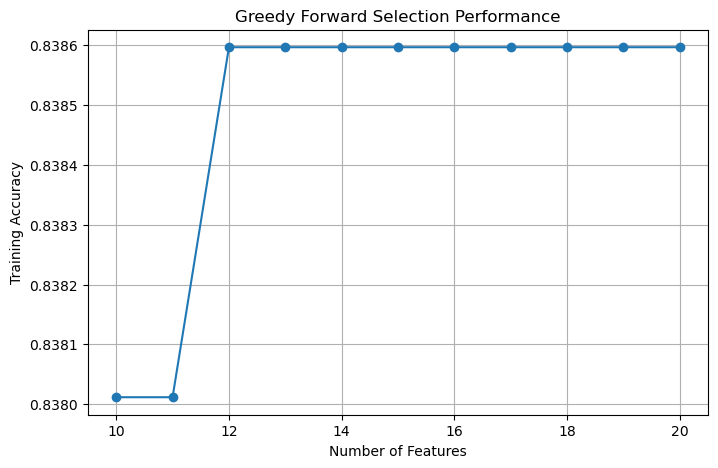


 Greedy Forward Selection complete.
Optimal number of features: 12
Best training accuracy: 0.8386
Cross-validated accuracy: 0.6199
Testing n_features_to_select = 26
Accuracy for 26 features: 0.8152
Testing n_features_to_select = 27
Accuracy for 27 features: 0.8152
Testing n_features_to_select = 28
Accuracy for 28 features: 0.8152
Testing n_features_to_select = 29
Accuracy for 29 features: 0.8152
Testing n_features_to_select = 30
Accuracy for 30 features: 0.8152
Testing n_features_to_select = 31
Accuracy for 31 features: 0.8152
Testing n_features_to_select = 32
Accuracy for 32 features: 0.8053
Testing n_features_to_select = 33
Accuracy for 33 features: 0.8158
Testing n_features_to_select = 34
Accuracy for 34 features: 0.8158
Testing n_features_to_select = 35
Accuracy for 35 features: 0.8263
Testing n_features_to_select = 36
Accuracy for 36 features: 0.8368


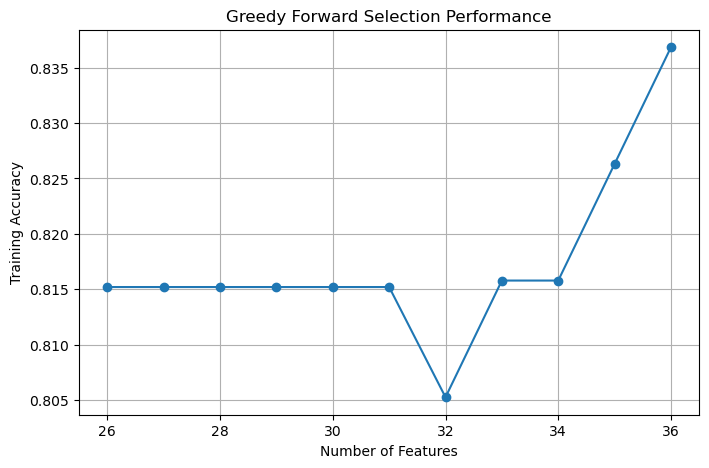


 Greedy Forward Selection complete.
Optimal number of features: 36
Best training accuracy: 0.8368


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 1011719.8061705176
Max alpha: 1011719.8061705178
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Cross-validated accuracy: 0.6094
Classifier: LogisticRegression
  Accuracy: 0.5326
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.5978
--------------------------------------------------
------------------------------Start training classifiers------------------------------


In [ ]:
"""
Performs 5-fold stratified cross-validation with full preprocessing, feature selection, model training, and evaluation.

For each fold:
1. Splits the dataset into a training and test set using Stratified K-Fold.
2. Handles missing data and scales the features using RobustScaler.
3. Applies multiple feature selection techniques:
   - Variance Threshold
   - ANOVA F-test
   - Mutual Information
   - Union of ANOVA & MI
   - Greedy Forward Selection for Logistic Regression and kNN
   - Lasso-based selection (with error handling)
   - PCA (retaining 95% explained variance)
4. Trains various classifiers
5. Generates and plots learning curves for all models.
6. Evaluates the best-performing model
7. Aggregates FPR, TPR, and AUC values across folds for later analysis."""

# Initialize 5-fold outer cross-validation
cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store values for ROC and AUC for each fold
all_fpr = []
all_tpr = []
all_auc = []

# Loop over the folds
for validation_index, test_index in cv_5fold.split(X, y):
    # Split the data properly
    print('=' * 30 + 'START ONE FOLD' + '=' * 30)
    X_train = X.iloc[validation_index]
    y_train = y.iloc[validation_index]

    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # Missing data
    total_missing = find_missing_data(X_train)
    X_train, X_test = process_missing_data(X_train, X_test, total_missing)

    # Scaling
    X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

    print('-' * 30 + 'Start feature selection' + '-' * 30)

    # Feature selection
    y_train_numeric, y_test_numeric = y_numeric(y_train, y_test) # Labels from categorical variable into numerical variable
    # Variance threshold
    X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
    # Anova
    X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    # MI
    X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    # Union Anova and MI
    X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
    
    # Selecting features for logistic regression 
    X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, sfs_selected_features_logistic, number_of_sfs_selected_features_logistic, train_acc_logistic = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=list(range(10, 21, 1)),
    scoring='accuracy'
    )

    # Selectig features for SVM by using logistic regression because of time with a maximum of 20 features
    X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, sfs_selected_features_logistic_max10, number_of_sfs_selected_features_logistic_max10, train_acc_logistic_max10 = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=list(range(10, 21, 1)),
    scoring='accuracy'
    )

    # Determine optimal k for kNN
    knn_best, _ = optimal_k(X_filtered_train_union_new, y_train_numeric)
    # Selecting features for kNN
    X_train_selected_sfs_knn, X_test_selected_sfs_knn, sfs_selected_features_knn, number_of_sfs_selected_features_knn, train_acc_knn = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=knn_best,
    feature_range=list(range(26, 37, 1)),
    scoring='accuracy'
    )
    
    # Try only the Lasso and its dependent parts
    try:
        alpha_info, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(
            X_scaled_robust_train, X_scaled_robust_test, y_train_numeric
        )

        print(f"Best alpha: {alpha_info[0]}")
        print(f"Max alpha: {alpha_info[1]}")
        print("Selected Features:", selected_feature_names)
        print(f"N features found: {n_features}")

        if n_features == 0:
            raise ValueError("No features were selected by Lasso.")

        # Only perform lasso if features are selected
        _, knn_best_lasso = optimal_k(X_train_sel_lasso, y_train_numeric)
        test_lasso(X_train_sel_lasso, y_train_numeric, knn_best_lasso)

    except ValueError as e:
        print(f"Skipping Lasso for this fold: {e}")

    # PCA
    pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95)
    _, knn_best_pca = optimal_k(X_train_pca, y_train_numeric)
    test_pca(X_train_pca, y_train_numeric, knn_best_pca)

    print('-' * 30 + 'Start training classifiers' + '-' * 30)

    # Classifiers
    best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)
    best_svm, best_score_svm = svm_classifier(X_train_selected_sfs_logistic_max10, y_train_encoded)
    best_knn, best_score_knn = knn_classifier(X_train_selected_sfs_knn, y_train_encoded)
    log_reg_score, log_reg_model = lr_classifier(X_train_selected_sfs_logistic, y_train_encoded)

    # Learning curves
    learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model, best_svm)

    # Evaluation
    fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators, best_svm, best_score_svm)

    # Save AUC and ROC values for each fold
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_value)

    print('=' * 30 + 'END ONE FOLD' + '=' * 30)


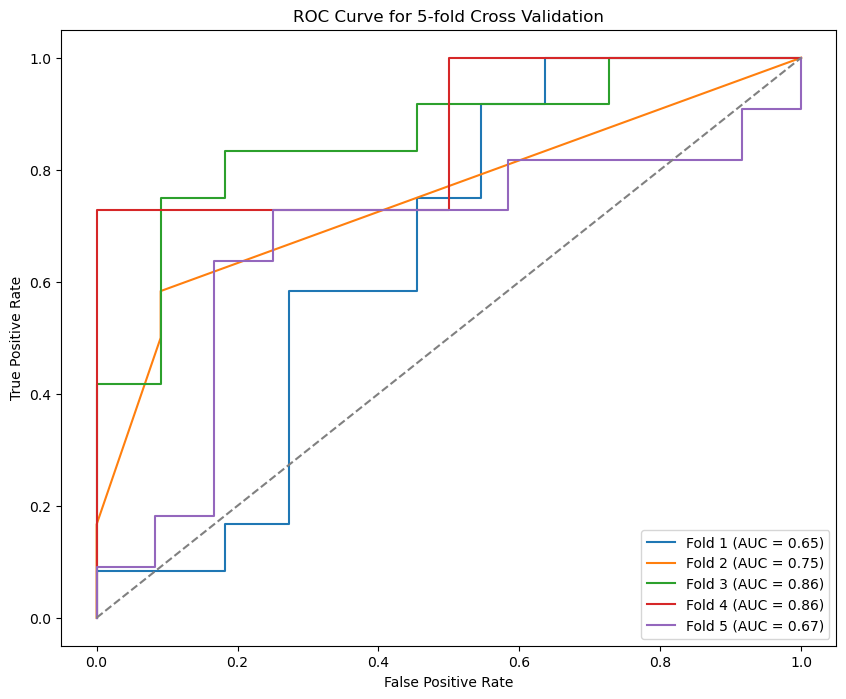

In [ ]:
"""
Plots the combined ROC curves for all 5 folds of the cross-validation.

Each ROC curve represents the performance of the best classifier selected 
in that fold. AUC scores are included in the legend for comparison.

Also includes a diagonal dashed line representing a random classifier 
(no-skill baseline) for reference."""

# Plot combined ROC
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)): # Plot seperate ROC curve for all folds
    plt.plot(all_fpr[i], all_tpr[i], label=f'Fold {i+1} (AUC = {all_auc[i]:.2f})') # AUC is mentioned in legend

# Plot a diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5-fold Cross Validation')
plt.legend(loc='lower right')
plt.show()

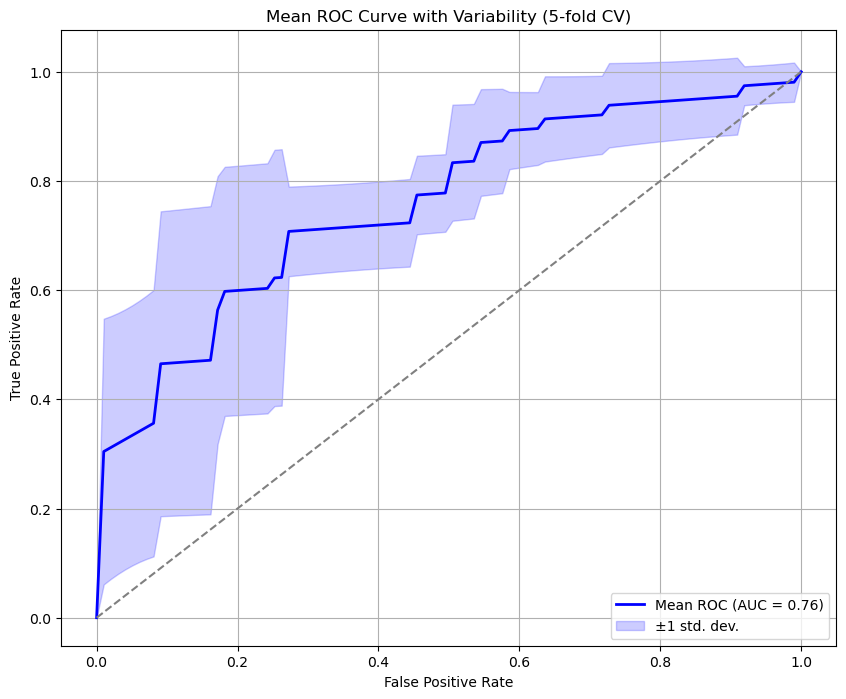

In [ ]:
"""
Plots the mean ROC curve with variability (standard deviation) for 5-fold cross-validation.

For each fold, the TPR is interpolated to a common FPR range, and the mean and 
standard deviation of the TPR values are computed. The resulting mean ROC curve 
is plotted along with a shaded area representing ±1 standard deviation to show 
the variability across folds.

The plot includes:
- The mean ROC curve.
- The standard deviation of the TPR at each FPR point.
- A diagonal dashed line representing a random classifier (no-skill baseline).

AUC for the mean ROC curve is also displayed in the legend.
"""

# Define common FPR range
mean_fpr = np.linspace(0, 1, 100)
interp_tprs = []

# Interpolate each fold's TPRs at mean_fpr points
for i in range(len(all_fpr)):
    interp_tpr = np.interp(mean_fpr, all_fpr[i], all_tpr[i])
    interp_tpr[0] = 0.0  # Ensure start at 0
    interp_tprs.append(interp_tpr)

interp_tprs = np.array(interp_tprs)
mean_tpr = np.mean(interp_tprs, axis=0) #Calculate mean true positive rate
std_tpr = np.std(interp_tprs, axis=0) #Calculate std true positive rate
mean_tpr[-1] = 1.0  # Ensure end at 1

mean_auc = auc(mean_fpr, mean_tpr) #Calculate mean AUC

# Plot mean ROC and shaded std deviation with mean AUC in the legend
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                 color='blue', alpha=0.2, label='±1 std. dev.')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Variability (5-fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
